In [11]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tensorflow.keras.utils import to_categorical
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [5]:
pip install tensorflow numpy matplotlib scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [6]:
pip install opencv-python


Note: you may need to restart the kernel to use updated packages.


In [2]:
import tensorflow as tf
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

In [3]:
df = pd.read_csv("/kaggle/input/fer2013/fer2013.csv")

In [5]:
y = to_categorical(df['emotion'].values, num_classes=len(df['emotion'].unique()))
X_train_str, X_val_str, y_train, y_val = train_test_split(
    df['pixels'].values,
    y,
    test_size=0.2,
    stratify=df['emotion'].values,
    random_state=42
)

In [6]:
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import preprocess_input

rot_layer = tf.keras.layers.RandomRotation(factor=0.06)  

def parse_row(pixels, label, augment=False):
    pixels = tf.strings.split(pixels)
    pixels = tf.strings.to_number(pixels, out_type=tf.float32)
    pixels = tf.reshape(pixels, (48, 48, 1))

    img = tf.image.resize(pixels, (224, 224))
    img = tf.image.grayscale_to_rgb(img)  

    if augment:
        img = tf.image.random_flip_left_right(img)
        img = tf.image.random_brightness(img, max_delta=0.25)
        img = tf.image.random_contrast(img, lower=0.75, upper=1.25)
        img = tf.image.random_saturation(img, lower=0.75, upper=1.25)
        img = rot_layer(img)
        scale = tf.random.uniform([], 0.85, 1.0)
        new_size = tf.cast(scale * 224, tf.int32)
        img = tf.image.random_crop(img, size=[new_size, new_size, 3])
        img = tf.image.resize(img, (224, 224))

        if tf.random.uniform([]) > 0.7:
            erase_w = tf.random.uniform([], 30, 60, dtype=tf.int32)
            erase_h = tf.random.uniform([], 30, 60, dtype=tf.int32)
            x = tf.random.uniform([], 0, 224 - erase_w, dtype=tf.int32)
            y = tf.random.uniform([], 0, 224 - erase_h, dtype=tf.int32)
            mask = tf.ones((erase_h, erase_w, 3))
            paddings = [[y, 224 - erase_h - y], [x, 224 - erase_w - x], [0, 0]]
            mask = tf.pad(mask, paddings, constant_values=0)
            img = img * (1 - mask)

    img = preprocess_input(img)
    return img, label


batch_size = 16

train_ds = (
    tf.data.Dataset.from_tensor_slices((X_train_str, y_train))
    .map(lambda x, y: parse_row(x, y, augment=True), num_parallel_calls=tf.data.AUTOTUNE)
    .shuffle(2000)
    .batch(batch_size)
    .prefetch(tf.data.AUTOTUNE)
)

val_ds = (
    tf.data.Dataset.from_tensor_slices((X_val_str, y_val))
    .map(lambda x, y: parse_row(x, y, augment=False), num_parallel_calls=tf.data.AUTOTUNE)
    .batch(batch_size)
    .prefetch(tf.data.AUTOTUNE)
)


In [8]:
base_model = ResNet50(weights="imagenet", include_top=False, input_shape=(224,224,3))
base_model.trainable = False  # Phase 1: freeze base

x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.5)(x)
output = Dense(y.shape[1], activation="softmax")(x)

model = Model(inputs=base_model.input, outputs=output)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [9]:
callbacks = [
    ModelCheckpoint("best_model.h5", save_best_only=True, monitor="val_accuracy", mode="max"),
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, verbose=1),
    EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
]

In [12]:
from sklearn.utils.class_weight import compute_class_weight

classes = np.arange(y.shape[1])  # [0..6]
y_integers = np.argmax(y_train, axis=1)

class_weights = compute_class_weight(
    class_weight="balanced",
    classes=classes,
    y=y_integers
)

class_weights = dict(enumerate(class_weights))
print("Class Weights:", class_weights)


Class Weights: {0: 1.035155404918151, 1: 9.363666014350946, 2: 1.0010460615781582, 3: 0.5703359357927568, 4: 0.8437123460781144, 5: 1.2808512536807353, 6: 0.8272056704892525}


In [13]:
model.compile(
    optimizer=Adam(1e-3), 
    loss="categorical_crossentropy",
    metrics=["accuracy"])
print("Phase 1 Training ...")
history_phase1 = model.fit(
    train_ds, 
    validation_data=val_ds, 
    epochs=5, 
    callbacks=callbacks)

Phase 1 Training ...
Epoch 1/5


I0000 00:00:1756985963.706698      81 service.cc:148] XLA service 0x79226c0ceec0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1756985963.707459      81 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1756985965.174916      81 cuda_dnn.cc:529] Loaded cuDNN version 90300


   4/1795 ━━━━━━━━━━━━━━━━━━━━ 1:35 53ms/step - accuracy: 0.0885 - loss: 3.0428  

I0000 00:00:1756985968.620704      81 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1795/1795 ━━━━━━━━━━━━━━━━━━━━ 152s 73ms/step - accuracy: 0.3289 - loss: 1.9107 - val_accuracy: 0.4770 - val_loss: 1.4756 - learning_rate: 0.0010
Epoch 2/5
1795/1795 ━━━━━━━━━━━━━━━━━━━━ 126s 67ms/step - accuracy: 0.4132 - loss: 1.6226 - val_accuracy: 0.4823 - val_loss: 1.4208 - learning_rate: 0.0010
Epoch 3/5
1795/1795 ━━━━━━━━━━━━━━━━━━━━ 128s 68ms/step - accuracy: 0.4073 - loss: 1.6406 - val_accuracy: 0.4875 - val_loss: 1.3798 - learning_rate: 0.0010
Epoch 4/5
1795/1795 ━━━━━━━━━━━━━━━━━━━━ 127s 67ms/step - accuracy: 0.4123 - loss: 1.6264 - val_accuracy: 0.4904 - val_loss: 1.3814 - learning_rate: 0.0010
Epoch 5/5
1793/1795 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.4164 - loss: 1.6162
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
1795/1795 ━━━━━━━━━━━━━━━━━━━━ 127s 67ms/step - accuracy: 0.4164 - loss: 1.6162 - val_accuracy: 0.4841 - val_loss: 1.3833 - learning_rate: 0.0010


In [14]:
model.save("/kaggle/working/emotion_model_phase1.h5")


In [15]:
from tensorflow.keras.models import load_model

model = load_model("/kaggle/working/emotion_model_phase1.h5")

for layer in model.layers[-50:]:
    layer.trainable = True

model.compile(optimizer=Adam(1e-4), loss="categorical_crossentropy", metrics=["accuracy"])

history_aug = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    class_weight=class_weights,
    callbacks=callbacks
)


Epoch 1/10
1795/1795 ━━━━━━━━━━━━━━━━━━━━ 201s 94ms/step - accuracy: 0.4141 - loss: 1.8312 - val_accuracy: 0.5910 - val_loss: 1.0873 - learning_rate: 1.0000e-04
Epoch 2/10
1795/1795 ━━━━━━━━━━━━━━━━━━━━ 162s 87ms/step - accuracy: 0.5390 - loss: 1.2270 - val_accuracy: 0.6082 - val_loss: 1.0312 - learning_rate: 1.0000e-04
Epoch 3/10
1795/1795 ━━━━━━━━━━━━━━━━━━━━ 163s 87ms/step - accuracy: 0.5700 - loss: 1.1174 - val_accuracy: 0.6333 - val_loss: 0.9909 - learning_rate: 1.0000e-04
Epoch 4/10
1795/1795 ━━━━━━━━━━━━━━━━━━━━ 162s 87ms/step - accuracy: 0.6027 - loss: 1.0315 - val_accuracy: 0.6407 - val_loss: 0.9989 - learning_rate: 1.0000e-04
Epoch 5/10
1795/1795 ━━━━━━━━━━━━━━━━━━━━ 162s 87ms/step - accuracy: 0.6569 - loss: 0.8757 - val_accuracy: 0.6707 - val_loss: 0.9196 - learning_rate: 5.0000e-05
Epoch 7/10
1795/1795 ━━━━━━━━━━━━━━━━━━━━ 163s 87ms/step - accuracy: 0.6775 - loss: 0.8179 - val_accuracy: 0.6769 - val_loss: 0.9014 - learning_rate: 5.0000e-05
Epoch 8/10
1795/1795 ━━━━━━━━━━━━━

In [16]:
model.save("/kaggle/working/emotion_model_phase2.h5")



In [18]:
import os

save_dir = "/kaggle/outputs/models"
os.makedirs(save_dir, exist_ok=True)

model.save(f"{save_dir}/emotion_model_phase2.h5")


In [20]:
!cp /kaggle/working/emotion_model_phase2.h5 /kaggle/outputs/


In [26]:
import os
print(os.listdir("/kaggle/working"))


['history_phase2.pkl', 'emotion_model_phase1.h5', 'history_phase1.json', 'history_phase2.json', 'best_model.h5', '.virtual_documents']


In [23]:
import json

with open("/kaggle/working/history_phase1.json", "w") as f:
    json.dump(history_phase1.history, f)

In [21]:
import json
with open("/kaggle/working/history_phase2.json", "w") as f:
    json.dump(history_aug.history, f)

In [24]:
import os
print(os.path.getsize("/kaggle/working/history_phase1.json"))

592


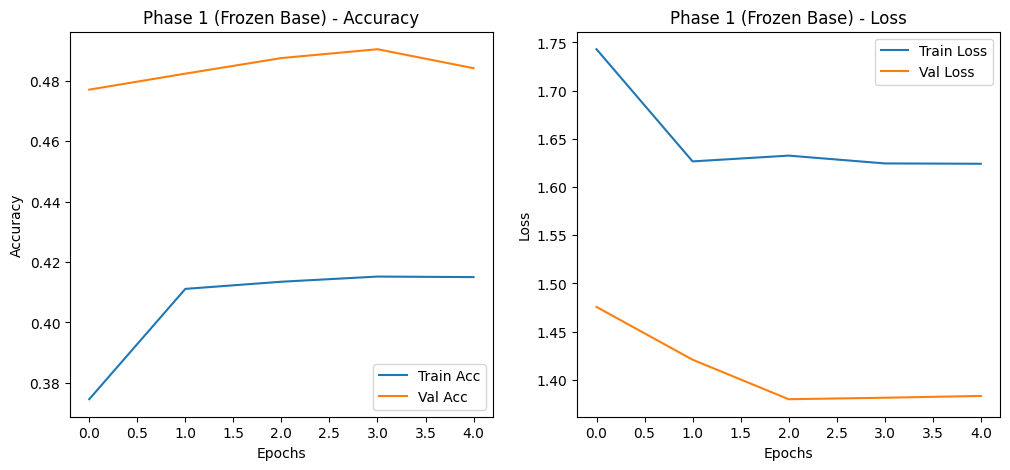

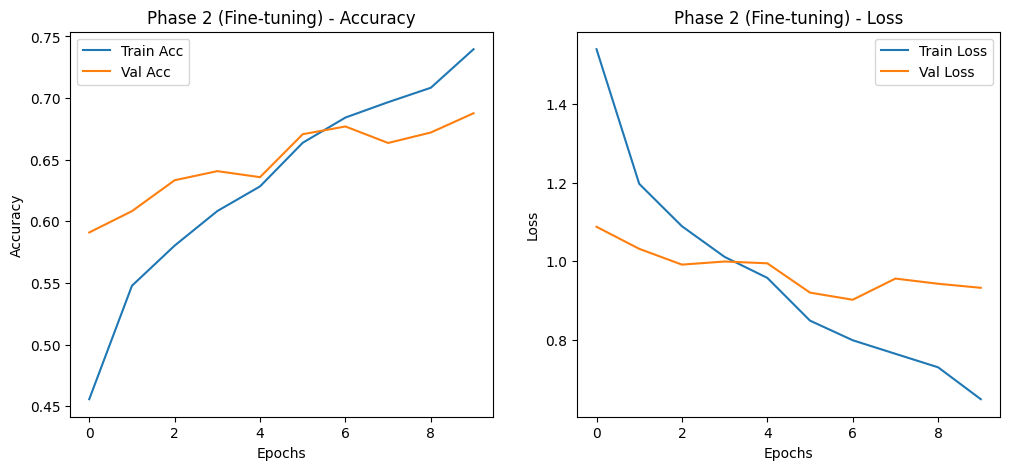

449/449 ━━━━━━━━━━━━━━━━━━━━ 19s 35ms/step
📊 Classification Report:
              precision    recall  f1-score   support

           0     0.5966    0.6044    0.6005       991
           1     0.6134    0.6697    0.6404       109
           2     0.5270    0.4678    0.4956      1024
           3     0.9076    0.8465    0.8760      1798
           4     0.5604    0.5987    0.5789      1216
           5     0.7310    0.8187    0.7724       800
           6     0.6303    0.6476    0.6388      1240

    accuracy                         0.6769      7178
   macro avg     0.6523    0.6648    0.6575      7178
weighted avg     0.6795    0.6769    0.6773      7178



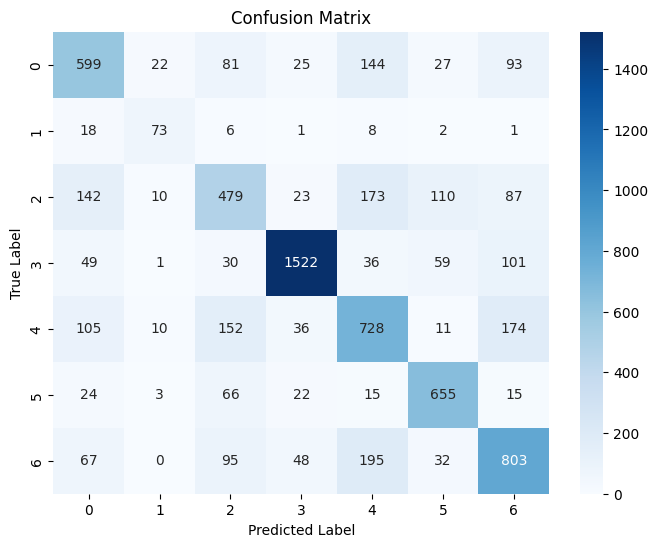

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import load_model

def plot_history(history, title):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history["accuracy"], label="Train Acc")
    plt.plot(history["val_accuracy"], label="Val Acc")
    plt.title(f"{title} - Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history["loss"], label="Train Loss")
    plt.plot(history["val_loss"], label="Val Loss")
    plt.title(f"{title} - Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    plt.show()

plot_history(history_phase1.history, "Phase 1 (Frozen Base)")

plot_history(history_aug.history, "Phase 2 (Fine-tuning)")

best_model = load_model("/kaggle/working/emotion_model_phase2.h5")

y_pred = np.argmax(best_model.predict(val_ds), axis=1)
y_true = np.argmax(y_val, axis=1)

print("📊 Classification Report:")
print(classification_report(y_true, y_pred, digits=4))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm, annot=True, fmt="d", cmap="Blues",
    xticklabels=range(len(df['emotion'].unique())),
    yticklabels=range(len(df['emotion'].unique()))
)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


In [22]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

model = load_model("/kaggle/working/emotion_model_phase2.h5")

for layer in model.layers:
    layer.trainable = True

In [23]:
loss_fn = CategoricalCrossentropy(label_smoothing=0.1)
optimizer = AdamW(learning_rate=1e-5, weight_decay=1e-6)

model.compile(
    optimizer=optimizer,
    loss=loss_fn,
    metrics=["accuracy"]
)
callbacks_phase3 = [
    EarlyStopping(
        monitor="val_loss",
        patience=6,
        restore_best_weights=True
    ),
    ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.5,
        patience=2,
        min_lr=1e-7
    ),
    ModelCheckpoint(
        f"{save_dir}/emotion_model_phase3_best.h5",
        monitor="val_accuracy",
        save_best_only=True,
        mode="max"
    )
]

In [24]:
history_phase3 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    class_weight=class_weights,
    callbacks=callbacks_phase3
)

Epoch 1/20
1795/1795 ━━━━━━━━━━━━━━━━━━━━ 328s 140ms/step - accuracy: 0.6042 - loss: 1.3037 - val_accuracy: 0.6580 - val_loss: 1.1962 - learning_rate: 1.0000e-05
Epoch 2/20
1795/1795 ━━━━━━━━━━━━━━━━━━━━ 234s 127ms/step - accuracy: 0.6568 - loss: 1.1350 - val_accuracy: 0.6669 - val_loss: 1.1582 - learning_rate: 1.0000e-05
Epoch 3/20
1795/1795 ━━━━━━━━━━━━━━━━━━━━ 234s 127ms/step - accuracy: 0.6851 - loss: 1.0866 - val_accuracy: 0.6812 - val_loss: 1.1426 - learning_rate: 1.0000e-05
Epoch 4/20
1795/1795 ━━━━━━━━━━━━━━━━━━━━ 234s 127ms/step - accuracy: 0.6970 - loss: 1.0545 - val_accuracy: 0.6868 - val_loss: 1.1319 - learning_rate: 1.0000e-05
Epoch 5/20
1795/1795 ━━━━━━━━━━━━━━━━━━━━ 235s 127ms/step - accuracy: 0.7158 - loss: 1.0227 - val_accuracy: 0.6909 - val_loss: 1.1281 - learning_rate: 1.0000e-05
Epoch 6/20
1795/1795 ━━━━━━━━━━━━━━━━━━━━ 234s 127ms/step - accuracy: 0.7264 - loss: 0.9941 - val_accuracy: 0.6921 - val_loss: 1.1238 - learning_rate: 1.0000e-05
Epoch 7/20
1795/1795 ━━━━━━━

In [27]:
model.save("/kaggle/working/emotion_model_phase3.h5")

In [26]:
import json
with open("/kaggle/working/history_phase3.json", "w") as f:
    json.dump(history_phase3.history, f)

449/449 ━━━━━━━━━━━━━━━━━━━━ 21s 38ms/step
📊 Classification Report:
              precision    recall  f1-score   support

           0     0.6576    0.5641    0.6073       991
           1     0.6356    0.6881    0.6608       109
           2     0.6209    0.4766    0.5392      1024
           3     0.8903    0.8760    0.8831      1798
           4     0.5693    0.6283    0.5973      1216
           5     0.7484    0.8512    0.7965       800
           6     0.6158    0.6968    0.6538      1240

    accuracy                         0.6974      7178
   macro avg     0.6768    0.6830    0.6769      7178
weighted avg     0.6983    0.6974    0.6949      7178



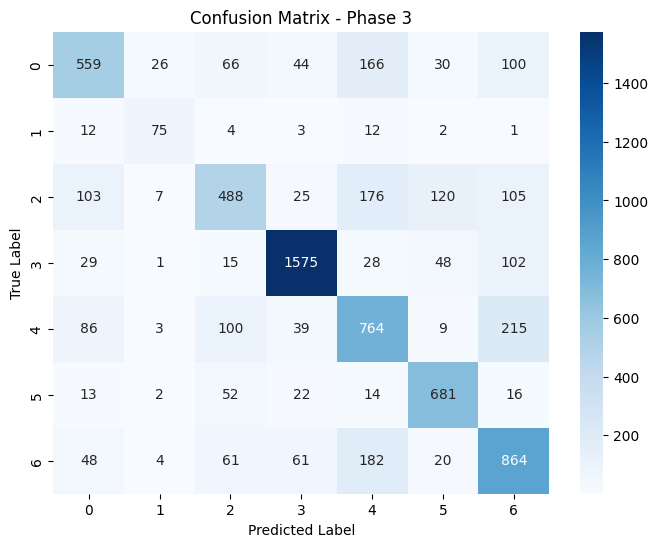

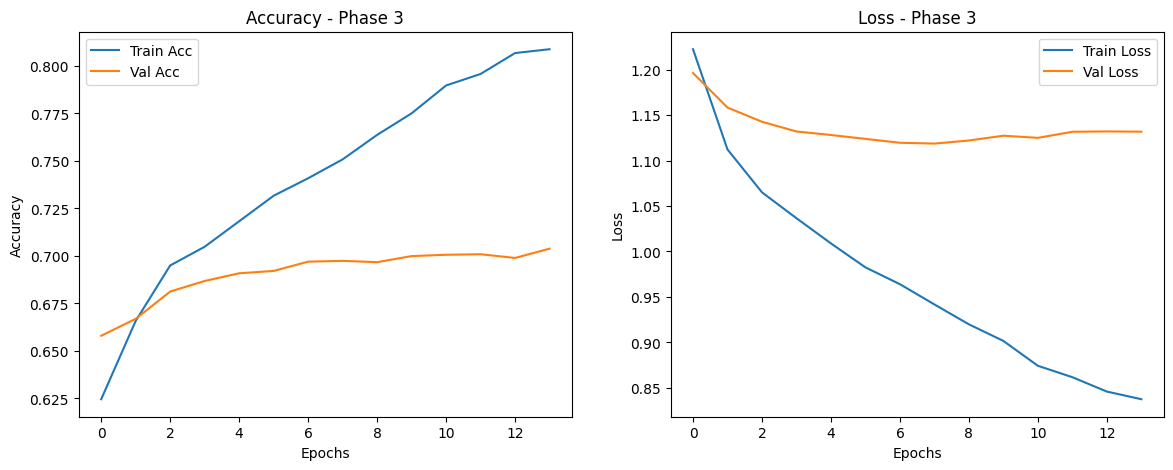

In [28]:
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import json

best_model = load_model("/kaggle/working/emotion_model_phase3.h5")

y_true = np.argmax(y_val, axis=1)
y_pred = np.argmax(best_model.predict(val_ds), axis=1)


print("Classification Report:")
print(classification_report(y_true, y_pred, digits=4))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=range(len(np.unique(y_true))),
            yticklabels=range(len(np.unique(y_true))))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Phase 3")
plt.show()

# ---------------------
# Load Training History (JSON format)
# ---------------------
with open("/kaggle/working/history_phase3.json", "r") as f:
    history_phase3 = json.load(f)


plt.figure(figsize=(14,5))

plt.subplot(1,2,1)
plt.plot(history_phase3["accuracy"], label="Train Acc")
plt.plot(history_phase3["val_accuracy"], label="Val Acc")
plt.title("Accuracy - Phase 3")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history_phase3["loss"], label="Train Loss")
plt.plot(history_phase3["val_loss"], label="Val Loss")
plt.title("Loss - Phase 3")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()


In [30]:
from tensorflow.keras.models import load_model
import numpy as np, tensorflow as tf
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

model = load_model("/kaggle/working/emotion_model_phase3.h5")  

def flip_map(img, y):
    return tf.image.flip_left_right(img), y

val_ds_flip = val_ds.map(flip_map, num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)

p1 = model.predict(val_ds, verbose=1)
p2 = model.predict(val_ds_flip, verbose=1)
p  = (p1 + p2) / 2.0
y_pred = p.argmax(axis=1)

ys = []
for _, y in val_ds:
    ys.append(y.numpy())
y_true = np.argmax(np.concatenate(ys, axis=0), axis=1)

print("TTA accuracy:", accuracy_score(y_true, y_pred))
print(classification_report(y_true, y_pred))
print(confusion_matrix(y_true, y_pred))


449/449 ━━━━━━━━━━━━━━━━━━━━ 20s 37ms/step
449/449 ━━━━━━━━━━━━━━━━━━━━ 14s 32ms/step
TTA accuracy: 0.7036779047088325
              precision    recall  f1-score   support

           0       0.66      0.56      0.61       991
           1       0.63      0.68      0.65       109
           2       0.64      0.48      0.55      1024
           3       0.89      0.88      0.89      1798
           4       0.58      0.63      0.61      1216
           5       0.75      0.86      0.80       800
           6       0.62      0.72      0.66      1240

    accuracy                           0.70      7178
   macro avg       0.68      0.69      0.68      7178
weighted avg       0.70      0.70      0.70      7178

[[ 557   30   66   40  165   28  105]
 [  15   74    4    3   10    2    1]
 [ 111    5  491   23  167  125  102]
 [  28    1   10 1586   21   52  100]
 [  76    4  103   39  768    8  218]
 [  14    1   44   25   11  688   17]
 [  49    3   48   58  175   20  887]]


In [31]:
model.save("/kaggle/working/emotion_model_phase3_final.h5")


In [32]:
from tensorflow.keras.models import load_model

model = load_model("emotion_model_phase3_final.h5")


In [33]:
from tensorflow.keras.models import load_model

model = load_model("/kaggle/working/emotion_model_phase3_final.h5")
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,602,057 (90.03 MB)

 Trainable params: 23,548,935 (89.83 MB)

 Non-trainable params: 53,120 (207.50 KB)

 Optimizer params: 2 (12.00 B)